In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from src.data.preprocess import create_paralog_clusters, query_paralogs
from src.utils.io import HDFReader
from tqdm import tqdm

### Preprocess paralogs

In [2]:
summary = pd.read_csv(
    Path("../data/summary.csv"), usecols=["gene", "chromosome", "strand"]
)
summary

,gene,chromosome,strand
0,YAL001C,chrI,-
1,YAL002W,chrI,+
2,YAL003W,chrI,+
3,YAL004W,chrI,+
4,YAL005C,chrI,-
...,...,...,...
6700,Q0182,chrM,+
6701,Q0250,chrM,+
6702,Q0255,chrM,+
6703,Q0275,chrM,+


In [3]:
genes = summary["gene"].tolist()
paralogs = query_paralogs(genes)
paralog_mapping = create_paralog_clusters(genes, paralogs)
summary["paralog_group"] = summary["gene"].map(paralog_mapping)

Querying BioMart for paralogs of 6705 genes...


In [4]:
summary

,gene,chromosome,strand,paralog_group
0,YAL001C,chrI,-,YAL001C
1,YAL002W,chrI,+,YAL002W
2,YAL003W,chrI,+,YAL003W
3,YAL004W,chrI,+,YAL004W
4,YAL005C,chrI,-,YKL073W
...,...,...,...,...
6700,Q0182,chrM,+,Q0182
6701,Q0250,chrM,+,Q0250
6702,Q0255,chrM,+,Q0255
6703,Q0275,chrM,+,Q0275


### How many genes have paralogs other than themselves?

In [5]:
# 1. Group by paralog_group and collect gene lists
paralog_groups = summary.groupby("paralog_group")["gene"].apply(list)

# 2. Create a set of genes that have at least one other paralog
genes_with_paralogs = set()
for group in paralog_groups:
    if len(group) > 1:
        genes_with_paralogs.update(group)

# 3. Filter summary for these genes
summary[summary["gene"].isin(genes_with_paralogs)]

,gene,chromosome,strand,paralog_group
1,YAL002W,chrI,+,YAL002W
4,YAL005C,chrI,-,YKL073W
5,YAL007C,chrI,-,YAL007C
10,YAL012W,chrI,+,YLL058W
13,YAL015C,chrI,-,YAL015C
...,...,...,...,...
6685,Q0070,chrM,+,Q0070
6690,Q0105,chrM,+,Q0110
6691,Q0110,chrM,+,Q0110
6692,Q0115,chrM,+,Q0110


### Paralog clusters analysis

In [6]:
reader = HDFReader(Path("../data/prepared/genewise.h5"))

# Create clusters DataFrame with group size
clusters = summary.groupby("paralog_group")["gene"].apply(list).reset_index()
clusters["size"] = clusters["gene"].apply(len)

# Filter clusters to those with size > 1
clusters = clusters[clusters["size"] > 1]
clusters["size"].value_counts().sort_index()

size
2     509
3     155
4      76
5      37
6      20
7       8
8       5
9       9
10      4
11      1
13      2
14      4
16      2
21      1
23      1
24      1
27      1
29      2
Name: count, dtype: int64

In [7]:
def get_pearson_correlation_from_cluster(
    genes: list[str], reader: HDFReader
) -> np.ndarray:
    """
    Calculate Pearson correlation for a given cluster of genes.
    Args:
        genes (list[str]): List of gene names in the cluster.
        reader (HDFReader): HDF5 reader to access gene embeddings and expressions.
    Returns:
        np.ndarray: Pearson correlation matrices for gene expressions.
    """
    exp = np.array([reader[g][1] for g in genes])
    variances = np.var(exp, axis=1)
    zero_var_mask = variances == 0

    if np.any(zero_var_mask):
        valid_indices = ~zero_var_mask

        if np.sum(valid_indices) < 2:
            return np.full((len(genes), len(genes)), np.nan)
        exp = exp[valid_indices]

    corr_matrix = np.corrcoef(exp)

    if corr_matrix.ndim == 0:
        corr_matrix = np.array([[1.0]])

    return corr_matrix

In [8]:
def compute_cluster_correlations(clusters: pd.DataFrame, reader: HDFReader) -> pd.Series:
    """
    Compute the mean intra-cluster Pearson correlation for each paralog cluster.

    Args:
        clusters (pd.DataFrame): DataFrame or Series mapping paralog_group to list of genes.
        reader (HDFReader): HDF5 reader to access gene expressions.

    Returns:
        pd.Series: Mean Pearson correlation for each cluster (indexed by paralog_group).
    """
    cluster_correlations = {}
    for i, genes in clusters.items():
        if len(genes) > 1:
            corr_matrix = get_pearson_correlation_from_cluster(genes, reader)

            # Check if correlation matrix contains NaN values
            if np.isnan(corr_matrix).all():
                continue

            upper_tri = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]

            # Filter out NaN values from upper triangle
            valid_correlations = upper_tri[~np.isnan(upper_tri)]

            if len(valid_correlations) > 0:
                cluster_correlations[i] = valid_correlations.mean()
            else:
                print(f"Skipping cluster {i} - no valid correlations")

    return pd.Series(cluster_correlations)


In [9]:
def sample_random_cluster(
    summary: pd.DataFrame, cluster_size: list[int] | None = None, random_state: int = 42
) -> pd.Series:
    """
    Sample random gene clusters to create a baseline for comparison.

    Args:
        summary (pd.DataFrame): DataFrame containing gene information
        cluster_size (Optional[List[int]]): List of cluster sizes to match.
                                          If None, extracts from paralog clusters in summary
        random_state (int): Random seed for reproducibility

    Returns:
        pd.Series: Series with random cluster IDs as index and gene lists as values
    """
    np.random.seed(random_state)

    # If cluster_size not provided, extract from existing paralog clusters
    if cluster_size is None:
        paralog_clusters = summary.groupby("paralog_group")["gene"].apply(list)
        cluster_size = [len(genes) for genes in paralog_clusters if len(genes) > 1]

    # Get all available genes
    all_genes = summary["gene"].tolist()

    random_clusters = {}

    for i, size in enumerate(cluster_size):
        # Randomly sample genes WITH replacement for this cluster
        sampled_genes = np.random.choice(all_genes, size=size, replace=True).tolist()
        random_clusters[f"random_{i}"] = sampled_genes

    return pd.Series(random_clusters)

In [ ]:
def visualize_comprehensive_cluster_heatmap(
    clusters: pd.Series, reader: HDFReader, top_n: int = 8
):
    """
    Generates a comprehensive heatmap showing both intra and inter-cluster correlations
    with visual indicators to distinguish between them.

    Args:
        clusters (pd.Series): Series mapping paralog_group to list of genes
        reader (HDFReader): HDF5 reader to access gene expressions
        top_n (int): Number of top clusters to visualize
    """
    correlation_series = compute_cluster_correlations(clusters, reader)
    top_clusters = correlation_series.nlargest(top_n)

    if len(top_clusters) == 0:
        print("No clusters to visualize.")
        return

    all_genes = []
    cluster_boundaries = []
    current_pos = 0

    # Collect all genes from top clusters in order
    for cluster_id in top_clusters.index:
        cluster_genes = clusters[cluster_id]
        all_genes.extend(cluster_genes)
        current_pos += len(cluster_genes)
        cluster_boundaries.append(current_pos)

    all_expressions = np.array([reader[g][1] for g in all_genes])
    full_corr_matrix = np.corrcoef(all_expressions)

    pos_to_cluster = {}
    current_pos = 0
    for i, cluster_id in enumerate(top_clusters.index):
        cluster_size = len(clusters[cluster_id])
        for j in range(cluster_size):
            pos_to_cluster[current_pos + j] = i
        current_pos += cluster_size

    annotations = np.full_like(full_corr_matrix, "", dtype=object)

    for i in range(len(all_genes)):
        for j in range(len(all_genes)):
            if i != j and abs(full_corr_matrix[i, j]) > 0.3:
                annotations[i, j] = f"{full_corr_matrix[i, j]:.2f}"

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 8), gridspec_kw={"width_ratios": [4, 1]}
    )

    sns.heatmap(
        full_corr_matrix,
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        xticklabels=all_genes,
        yticklabels=all_genes,
        annot=annotations,
        fmt="",
        annot_kws={"size": 8},
        ax=ax1,
        cbar_kws={"label": "Pearson Correlation"},
    )

    for i, boundary in enumerate(cluster_boundaries[:-1]):
        ax1.axhline(y=boundary, color="black", linewidth=3)
        ax1.axvline(x=boundary, color="black", linewidth=3)

    ax1.set_title(
        f"Paralog Clusters Correlation Matrix (Top {top_n})", fontsize=14, pad=20
    )
    ax1.set_xlabel("Genes (Grouped by Paralog Cluster)", fontsize=12)
    ax1.set_ylabel("Genes (Grouped by Paralog Cluster)", fontsize=12)

    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\nComprehensive Summary for ALL {len(correlation_series)} Paralog Clusters:")
    print("=" * 60)

    all_correlation_values = correlation_series.values
    print("Overall cluster correlation statistics:")
    print(f"  Mean: {np.mean(all_correlation_values):.3f}")
    print(f"  Median: {np.median(all_correlation_values):.3f}")
    print(f"  Std: {np.std(all_correlation_values):.3f}")
    print(f"  Min: {np.min(all_correlation_values):.3f}")
    print(f"  Max: {np.max(all_correlation_values):.3f}")

    high_corr = correlation_series[correlation_series > 0.7]
    medium_corr = correlation_series[
        (correlation_series >= 0.3) & (correlation_series <= 0.7)
    ]
    low_corr = correlation_series[correlation_series < 0.3]

    print("\nCluster categories:")
    print(f"  High correlation (r > 0.7): {len(high_corr)} clusters")
    print(f"  Medium correlation (0.3 ≤ r ≤ 0.7): {len(medium_corr)} clusters")
    print(f"  Low correlation (r < 0.3): {len(low_corr)} clusters")

    print("\nTop 20 most correlated clusters:")
    for i, (cluster_id, corr_val) in enumerate(
        correlation_series.nlargest(20).items(), 1
    ):
        cluster_genes = clusters[cluster_id]
        print(f"  {i:2d}. Cluster {cluster_id}: {corr_val:.3f} - {cluster_genes}")

    print("\nBottom 5 least correlated clusters:")
    for i, (cluster_id, corr_val) in enumerate(
        correlation_series.nsmallest(5).items(), 1
    ):
        cluster_genes = clusters[cluster_id]
        print(f"  {i:2d}. Cluster {cluster_id}: {corr_val:.3f} - {cluster_genes}")

### Average correlation for each paralog cluster

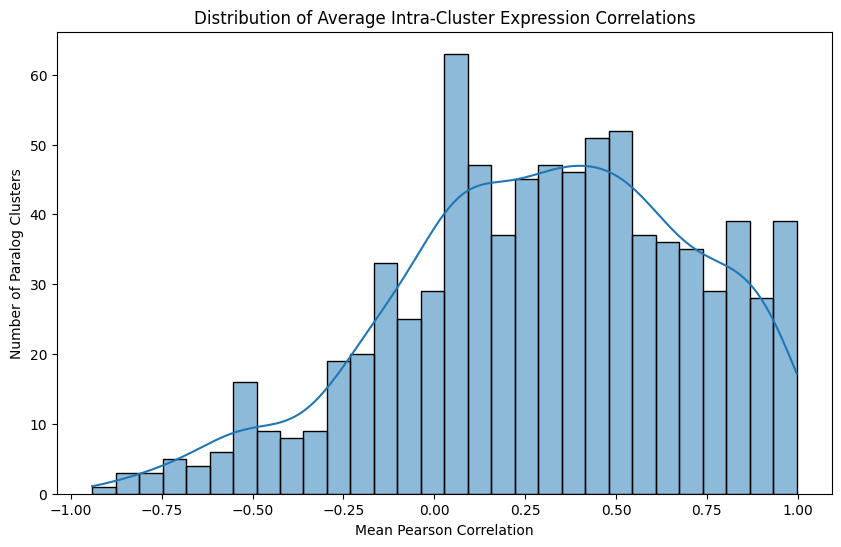

In [11]:
paralog_corr = compute_cluster_correlations(clusters["gene"], reader)

plt.figure(figsize=(10, 6))
sns.histplot(paralog_corr, kde=True, bins=30)
plt.title("Distribution of Average Intra-Cluster Expression Correlations")
plt.xlabel("Mean Pearson Correlation")
plt.ylabel("Number of Paralog Clusters")
plt.show()

### Average correlation for random grouped cluster

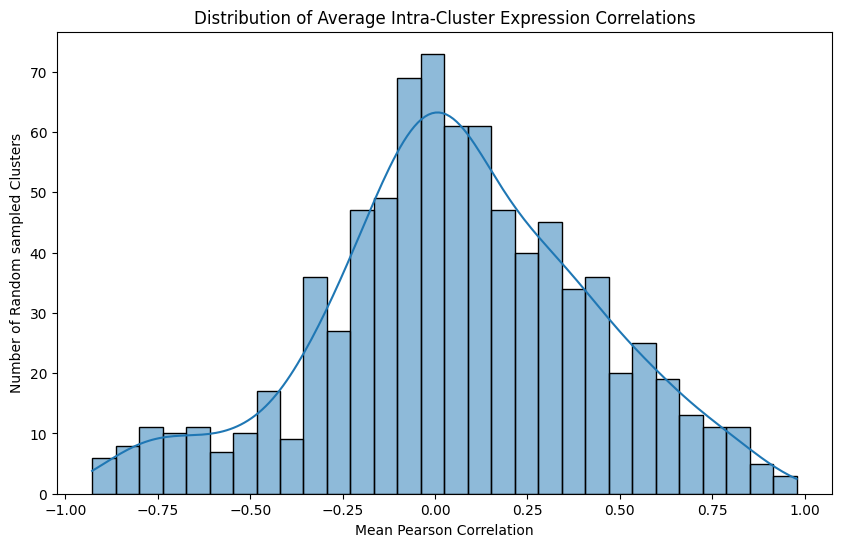

In [12]:
random_corr = compute_cluster_correlations(
    sample_random_cluster(summary, cluster_size=clusters["size"].tolist()),
    reader,
)

plt.figure(figsize=(10, 6))
sns.histplot(random_corr, kde=True, bins=30)
plt.title("Distribution of Average Intra-Cluster Expression Correlations")
plt.xlabel("Mean Pearson Correlation")
plt.ylabel("Number of Random sampled Clusters")
plt.show()

### Do paralog clusters have higher average intra-cluster correlation than random clusters?

In [24]:
from scipy.stats import mannwhitneyu

# Perform the one-sided test
statistic, p_value = mannwhitneyu(paralog_corr, random_corr, alternative="greater")

print("Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value:.10f}")

alpha = 0.05
print(
    "The average correlation in paralog clusters is significantly higher than in random clusters."
) if p_value < alpha else print(
    "There is no significant difference in correlation between paralog and random clusters."
)


Mann-Whitney U test results:
Statistic: 457294.0
P-value: 0.0000000000
The average correlation in paralog clusters is significantly higher than in random clusters.


### HeatMap for paralog clusters with intra/inter cluster correlation

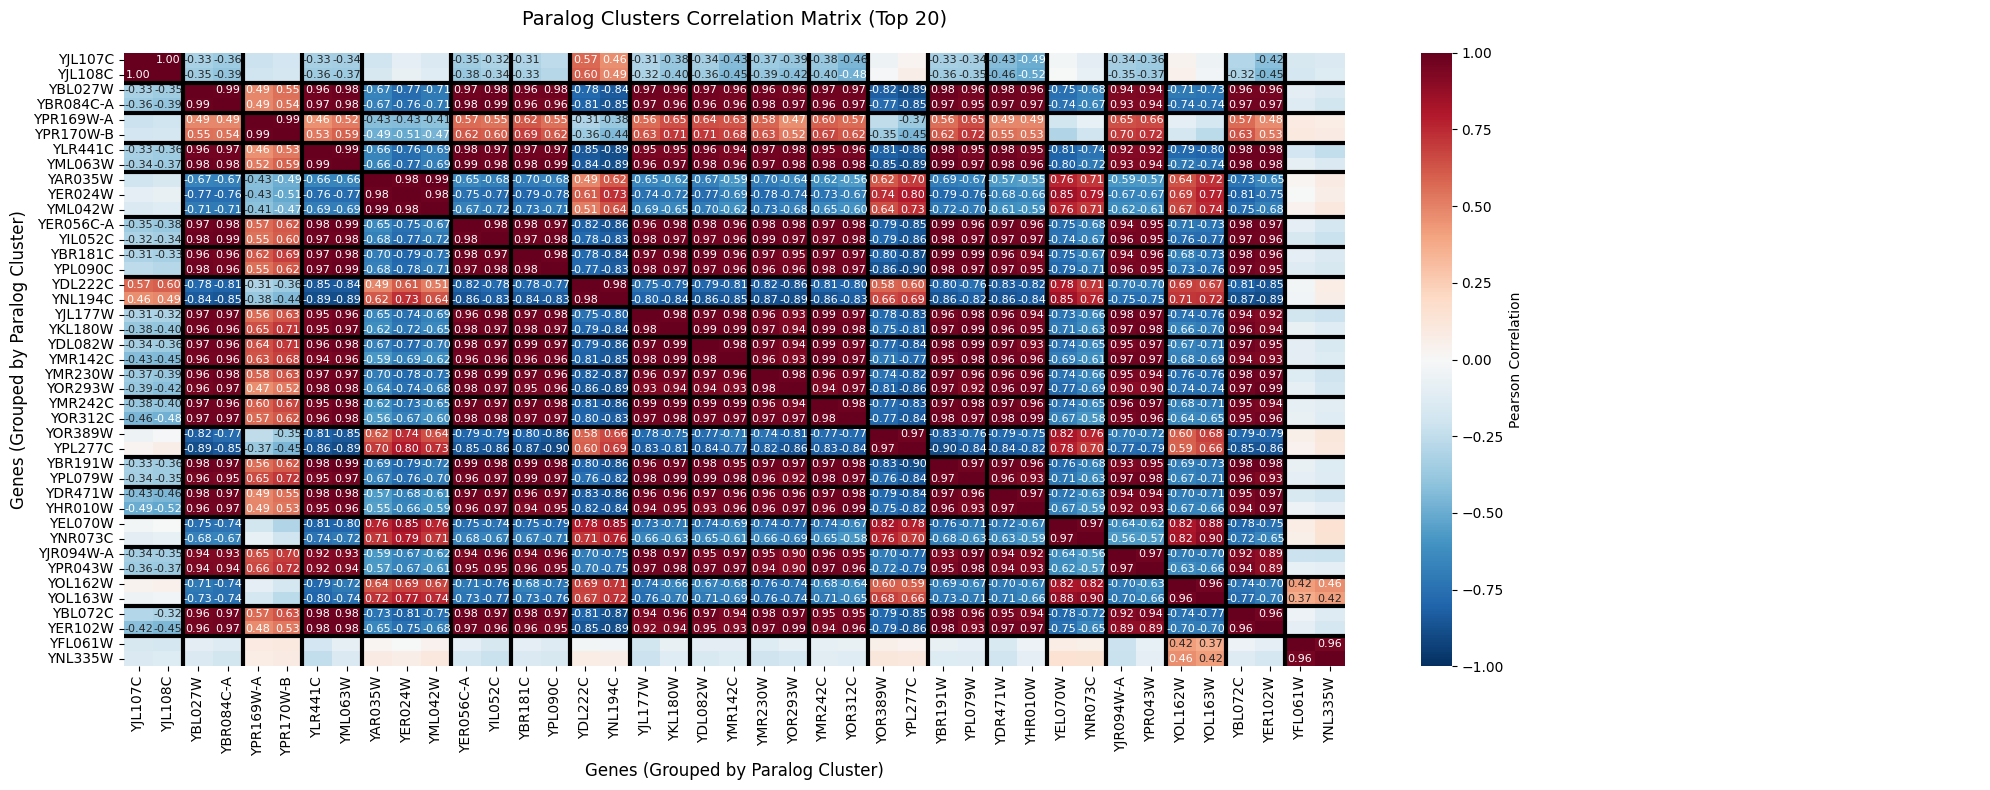


Comprehensive Summary for ALL 821 Paralog Clusters:
Overall cluster correlation statistics:
  Mean: 0.303
  Median: 0.325
  Std: 0.407
  Min: -0.941
  Max: 0.997

Cluster categories:
  High correlation (r > 0.7): 150 clusters
  Medium correlation (0.3 ≤ r ≤ 0.7): 278 clusters
  Low correlation (r < 0.3): 393 clusters

Top 20 most correlated clusters:
   1. Cluster 2501: 0.997 - ['YJL107C', 'YJL108C']
   2. Cluster 254: 0.991 - ['YBL027W', 'YBR084C-A']
   3. Cluster 4932: 0.989 - ['YPR169W-A', 'YPR170W-B']
   4. Cluster 3384: 0.986 - ['YLR441C', 'YML063W']
   5. Cluster 1297: 0.986 - ['YAR035W', 'YER024W', 'YML042W']
   6. Cluster 2275: 0.983 - ['YER056C-A', 'YIL052C']
   7. Cluster 340: 0.982 - ['YBR181C', 'YPL090C']
   8. Cluster 749: 0.981 - ['YDL222C', 'YNL194C']
   9. Cluster 2559: 0.979 - ['YJL177W', 'YKL180W']
  10. Cluster 645: 0.979 - ['YDL082W', 'YMR142C']
  11. Cluster 3718: 0.977 - ['YMR230W', 'YOR293W']
  12. Cluster 4503: 0.977 - ['YMR242C', 'YOR312C']
  13. Cluster 4783:

In [14]:
visualize_comprehensive_cluster_heatmap(clusters["gene"], reader, top_n=20)

### Analysis of Paralog Correlation in DNA Embeddings

In [15]:
def extract_gene_embeddings(genes: list[str], reader: HDFReader) -> np.ndarray:
    """
    Extract mean DNA embeddings for a list of genes.

    Args:
        genes (list[str]): List of gene names
        reader (HDFReader): HDF5 reader to access gene embeddings

    Returns:
        np.ndarray: Matrix of embeddings (n_genes, 768)
    """
    embeddings = []
    valid_genes = []

    for gene in genes:
        try:
            gene_embedding = reader[gene][0]
            mean_embedding = np.mean(gene_embedding, axis=0)  # Shape: (768,)
            embeddings.append(mean_embedding)
            valid_genes.append(gene)
        except Exception as e:
            print(f"Skipping gene {gene}: {e}")
            continue

    if len(embeddings) == 0:
        return np.array([]), []

    return np.array(embeddings), valid_genes

In [16]:
def compute_cosine_similarities(clusters: pd.Series, reader: HDFReader) -> np.ndarray:
    """
    Compute all pairwise cosine similarities within paralog clusters.

    Args:
        clusters (pd.Series): Series mapping paralog_group to list of genes
        reader (HDFReader): HDF5 reader to access gene embeddings

    Returns:
        np.ndarray: Array of all cosine similarities within paralog clusters
    """
    all_similarities = []

    print(f"Computing cosine similarities for {len(clusters)} clusters...")

    for cluster_id, genes in tqdm(clusters.items(), desc="Processing clusters"):
        if len(genes) < 2:
            continue

        embeddings, valid_genes = extract_gene_embeddings(genes, reader)

        if len(valid_genes) < 2:
            print(f"Skipping cluster {cluster_id} - insufficient valid genes")
            continue

        similarity_matrix = cosine_similarity(embeddings)

        n_genes = len(valid_genes)
        upper_tri_indices = np.triu_indices(n_genes, k=1)
        similarities = similarity_matrix[upper_tri_indices]

        all_similarities.extend(similarities)

    similarities_array = np.array(all_similarities)
    print(f"Computed {len(similarities_array)} paralog cosine similarities")
    print(f"Mean similarity: {similarities_array.mean():.4f}")
    print(f"Std similarity: {similarities_array.std():.4f}")

    return similarities_array

In [17]:
paralog_cosine_similarities = compute_cosine_similarities(clusters["gene"], reader)

Computing cosine similarities for 838 clusters...


Processing clusters: 838it [00:18, 45.10it/s]

Computed 5629 paralog cosine similarities
Mean similarity: 0.9922
Std similarity: 0.0069


In [18]:
random_cosine_similarities = compute_cosine_similarities(
    sample_random_cluster(summary, cluster_size=clusters["size"].tolist()), reader
)

Computing cosine similarities for 838 clusters...


Processing clusters: 838it [00:18, 46.02it/s]

Computed 5629 paralog cosine similarities
Mean similarity: 0.9888
Std similarity: 0.0083


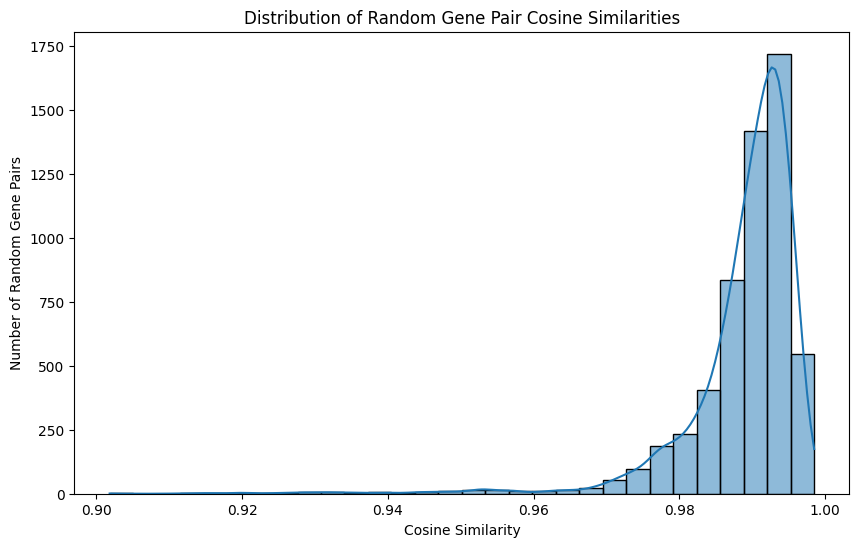

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(random_cosine_similarities, kde=True, bins=30)
plt.title("Distribution of Random Gene Pair Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Random Gene Pairs")
plt.show()

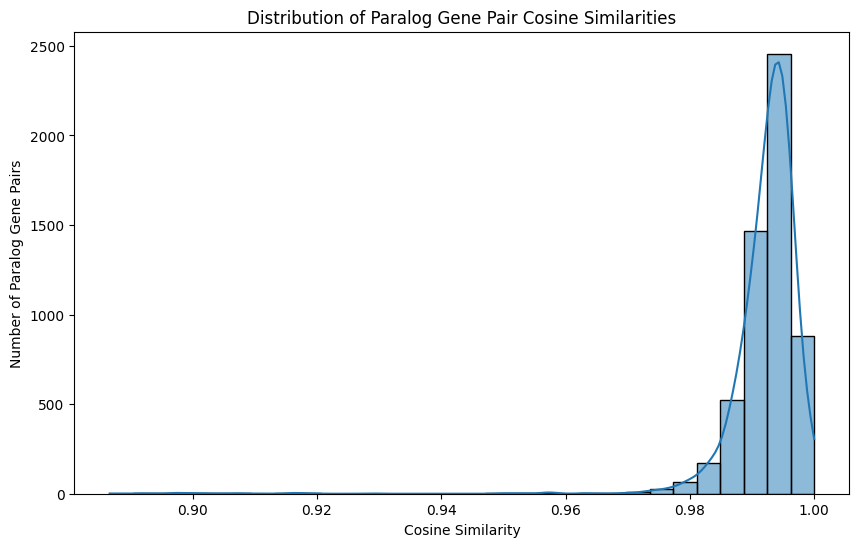

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(paralog_cosine_similarities, kde=True, bins=30)
plt.title("Distribution of Paralog Gene Pair Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Paralog Gene Pairs")
plt.show()

### Do SpeciesLM embeddings of paralogous genes show higher similarity to each other than to random genes?

In [23]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(
    paralog_cosine_similarities, random_cosine_similarities, alternative="greater"
)

print("Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value:.10f}")

alpha = 0.05
print(
    "The average cosine similarity in paralog clusters is significantly higher than in random clusters."
) if p_value < alpha else print(
    "There is no significant difference in cosine similarity between paralog and random clusters."
)


Mann-Whitney U test results:
Statistic: 21217372.5
P-value: 0.0000000000
The average cosine similarity in paralog clusters is significantly higher than in random clusters.
